# Redes Neuronales Convolucionales (CNN)

## Proyecto 2: Clasificación de enfermedades en plantas


**Objetivo:** El objetivo de este proyecto es construir una red neuronal convolucional (CNN) para clasificar enfermedades en plantas basándonos en imágenes.

**Dataset:** Utilizaremos el dataset *Plant Stress Identification (Paddy Leaves)* de Kaggle, que incluye imágenes térmicas de hojas enfermas y sanas de cultivos de arroz.

**Fuente:** *https://www.kaggle.com/datasets/ritikbompilwar/plantstressidentification*

**Tabla de contenidos**   
1. [Importar librerias y otro codigo util](#importar-librerias-y-otro-código-útil)
2. [Acceso y preparacion de los datos](#acceso-y-prepraracion-de-los-datos)
3. [Preprocesamiento de los datos](#preprocesamiento-de-los-datos)
4. [Creacion y compilacion del modelo](#creacion-y-compilacion-del-modelo)
5. [Entrenamiento y evaluacion del modelo](#entrenamiento-y-evaluacion-del-modelo)
6. [Graficos](#graficos)
7. [Predicciones](#predicciones)
8. [Visualizacion de los reportes de clasificacion y matriz de confusion](#visualizacion-de-los-reportes-de-clasificacion-y-matriz-de-confusion)
9. [Conclusiones finales](#conclusiones-finales)

### Importar librerias y otro codigo util

In [2]:
# LIBRERIAS
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from pathlib import Path
import os.path

# Visualización de datos
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Tensorflow 
from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0

# Metricas
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [5]:
# HELPER_FUNCTIONS: Funciones auxiliares útiles --> url = 'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py'

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

### Acceso y preparacion de los datos

In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [7]:
# Recorre cada directorio
dataset = "../data/archive/Dataset"
walk_through_dir(dataset)

There are 3 directories and 0 images in '../data/archive/Dataset'.
There are 5 directories and 0 images in '../data/archive/Dataset\test'.
There are 0 directories and 48 images in '../data/archive/Dataset\test\Blast'.
There are 0 directories and 44 images in '../data/archive/Dataset\test\BLB'.
There are 0 directories and 47 images in '../data/archive/Dataset\test\healthy'.
There are 0 directories and 43 images in '../data/archive/Dataset\test\hispa'.
There are 0 directories and 40 images in '../data/archive/Dataset\test\leaf_spot'.
There are 5 directories and 0 images in '../data/archive/Dataset\train'.
There are 0 directories and 328 images in '../data/archive/Dataset\train\Blast'.
There are 0 directories and 308 images in '../data/archive/Dataset\train\BLB'.
There are 0 directories and 325 images in '../data/archive/Dataset\train\healthy'.
There are 0 directories and 298 images in '../data/archive/Dataset\train\hispa'.
There are 0 directories and 280 images in '../data/archive/Datase

- Crear dataframe

In [8]:
# Dataset es una cadena con la ruta al directorio de los datos. Path convierte la ruta al dataset en un objeto Path, y así puede usar métodos útiles del objeto Path
image_dir = Path(dataset)

# Lista todos los archivos jpg y png
# .glob busca archivos que coincidan con un patrón
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

# Extraer las etiquetas asociadas a las imágenes (ruta al directorio + nombre del directorio)
# Funciona así:
# os.path.split('/ruta/a/dataset/categoria1/imagen1.jpg') -> ('/ruta/a/dataset/categoria1', 'imagen1.jpg')
# os.path.split('/ruta/a/dataset/categoria1')[0] -> '/ruta/a/dataset/categoria1'
# os.path.split('/ruta/a/dataset/categoria1') -> ('/ruta/a/dataset', 'categoria1')
# os.path.split('/ruta/a/dataset/categoria1')[1] -> 'categoria1'
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Crear series de pandas 
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenar la información en 2 columnas
image_df = pd.concat([filepaths, labels], axis=1)

In [15]:
image_df.head()

,Filepath,Label
0,..\data\archive\Dataset\test\Blast\Thermalimag...,Blast
1,..\data\archive\Dataset\test\Blast\Thermalimag...,Blast
2,..\data\archive\Dataset\test\Blast\Thermalimag...,Blast
3,..\data\archive\Dataset\test\Blast\Thermalimag...,Blast
4,..\data\archive\Dataset\test\Blast\Thermalimag...,Blast


- Visualización de imágenes

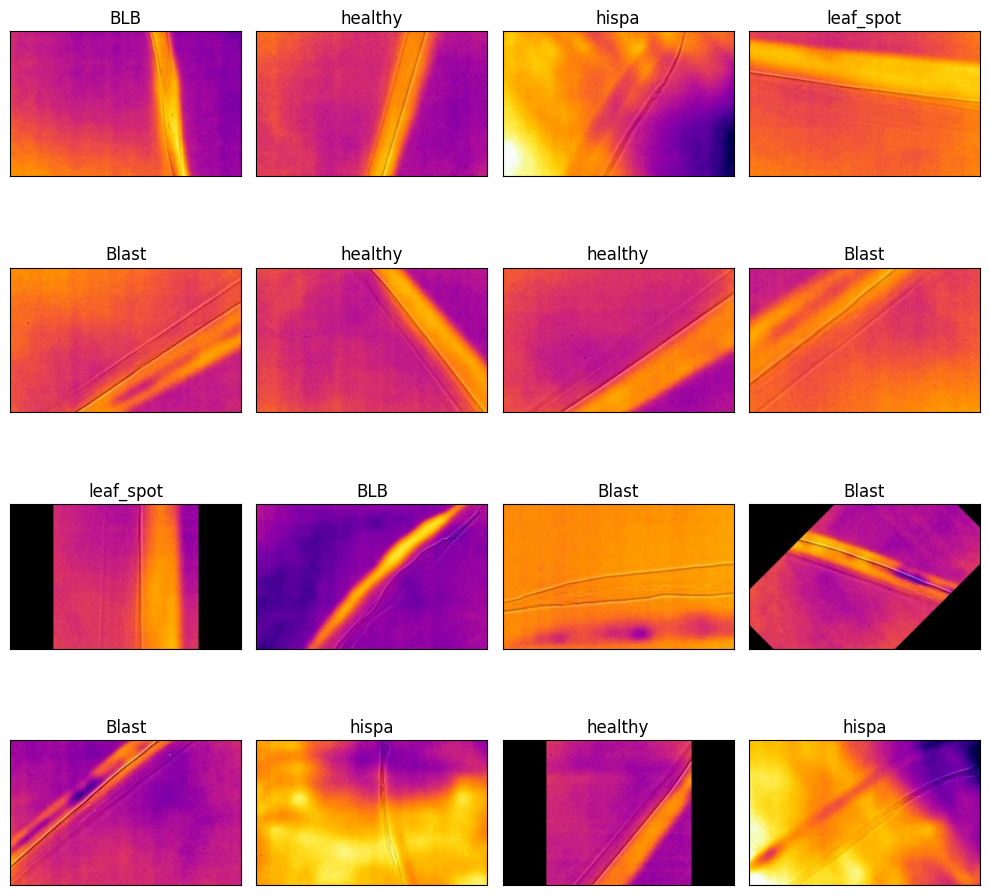

In [16]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(4, 4, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})

for ax, idx in zip(axes.flat, random_index): # axes.flat recorre la cuadricula como una lista plana
    ax.imshow(plt.imread(image_df.loc[idx, 'Filepath'])) # imread carga la imagen desde la ruta especificada
    ax.set_title(image_df.loc[idx, 'Label'])

plt.tight_layout()
plt.show()

### Preprocesamiento de los datos

Los datos se dividirán en tres categorías diferentes: **Entrenamiento, Validación y Prueba**. Los datos de entrenamiento se utilizarán para entrenar el modelo CNN de aprendizaje profundo y sus parámetros se ajustarán con los datos de validación.

In [9]:
# Separar el dataframe en datos de entrenamiento (train, 80%) y prueba (test, 20%)
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42, stratify=image_df['Label'])

In [10]:
# Funciones de preprocesamiento (normalizacion, Data Augmentation...). Configuramos un ImageDataGenerator que incluye preprocesamiento y división de datos:

# Data Augmentation a los datos de entrenamiento
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,  
    zoom_range=0.2,  # Agrega zoom aleatorio
    brightness_range=[0.8, 1.2],  # Agrega ajuste de brillo
    validation_split=0.2 # El 20% de los datos de entrenamiento se reservarán para validación 
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [11]:
# Transformacion en lotes de los datos de entrenamiento

# El método .flow_from_dataframe() de la clase ImageDataGenerator en Keras es una función clave
# para cargar datos de imágenes y etiquetas desde un DataFrame de pandas y generar lotes de datos
# que pueden ser alimentados a un modelo de aprendizaje automático durante el entrenamiento o la evaluación. 

# Carga de imágenes de entrenamiento
train_images = train_datagen.flow_from_dataframe( # Aplica las transformaciones y el preprocesamiento definidos en el ImageDataGenerator. 
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training' # Esto indica que quieres el 80% de los datos, que se ha reservado para el entrenamiento.
)

# Carga de imágenes de validación
val_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation' # Indica que este generador es para validación
)

# Carga de imágenes de prueba
test_images = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False # No se barajan las imágenes de prueba
)

Found 2816 validated image filenames belonging to 5 classes.
Found 704 validated image filenames belonging to 5 classes.
Found 880 validated image filenames belonging to 5 classes.


In [34]:
# Ver las clases del modelo, necesario para el script de Python
class_indices = train_images.class_indices
print(class_indices)

{'BLB': 0, 'Blast': 1, 'healthy': 2, 'hispa': 3, 'leaf_spot': 4}


### Creacion y compilacion del modelo

Las imágenes modelo se someterán a un modelo CNN preentrenado denominado *efficientnetb0*. Se utilizarán dos callbacks para supervisar el entrenamiento. Estas son: **Model Checkpoint y Early Stopping**.

In [18]:
num_clases = train_df['Label'].nunique() # para definir el número de clases (categorías) en la capa densa

In [19]:
# Cargar modelo preentrenado con efficientnetb0 (buena opción para clasificación de imágenes con menor carga computacional, y tamaño de entrada 224x224)
base_model = EfficientNetB0(
    weights='imagenet', # Pesos preentrenados en ImageNet
    include_top=False, # Excluye la capa de clasificación final
    pooling='max', # Aplica pooling global máximo
    input_shape=(224, 224, 3))

# Congelar las capas base para evitar su entrenamiento: Esto establece que las capas del modelo base no deben actualizar sus pesos durante el entrenamiento.
# Solo las capas añadidas después de la capa base serán entrenadas.
base_model.trainable = False

# Definicion del modelo con capas adicionales
model = tf.keras.Sequential([
    
    base_model,  # Añadir el modelo preentrenado
    layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),  # Normalización por lotes, para acelerar el entrenamiento y mejorar la estabilidad del modelo
    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.016), activity_regularizer=tf.keras.regularizers.l1(0.006),
                 bias_regularizer=tf.keras.regularizers.l1(0.006), activation='relu'),  # Capa densa con regularización
    layers.Dropout(rate=0.45, seed=123),  # Dropout para evitar el sobreajuste
    layers.Dense(num_clases, activation='softmax')  # Capa de salida para clasificación
])

# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Permite detener el entrenamiento antes de que el modelo empiece a sobreajustarse a los datos de entrenamiento, basándose en el rendimiento del modelo en los datos de validación.
model_checkpoint = ModelCheckpoint('models/plant_stress_model.keras', monitor="val_accuracy", save_best_only=True) # guarda el modelo en su mejor estado durante el entrenamiento. 
# ModelCheckpoint está diseñado para guardar los pesos del modelo en el mejor estado durante el entrenamiento, pero no incluye la arquitectura del modelo.

# Compilación del modelo
model.compile(optimizer=Adam(0.0001), # Optimización con un learning rate específico
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Entrenamiento y evaluacion del modelo

In [20]:
# Entrenamiento del modelo
print("Entrenando modelo...");
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=40,
    callbacks=[
        early_stopping,
        model_checkpoint,
    ]
)
print("Modelo entrenado!");

Entrenando modelo...
Epoch 1/40
88/88 [==============================] - 204s 2s/step - loss: 9.0934 - accuracy: 0.4073 - val_loss: 8.4203 - val_accuracy: 0.6037
Epoch 2/40
88/88 [==============================] - 135s 2s/step - loss: 8.1946 - accuracy: 0.5735 - val_loss: 7.6244 - val_accuracy: 0.7287
Epoch 3/40
88/88 [==============================] - 134s 2s/step - loss: 7.5803 - accuracy: 0.6559 - val_loss: 7.0994 - val_accuracy: 0.7557
Epoch 4/40
88/88 [==============================] - 135s 2s/step - loss: 7.1134 - accuracy: 0.6811 - val_loss: 6.6435 - val_accuracy: 0.7841
Epoch 5/40
88/88 [==============================] - 135s 2s/step - loss: 6.6681 - accuracy: 0.7113 - val_loss: 6.2727 - val_accuracy: 0.7940
Epoch 6/40
88/88 [==============================] - 134s 2s/step - loss: 6.2633 - accuracy: 0.7312 - val_loss: 5.8735 - val_accuracy: 0.8224
Epoch 7/40
88/88 [==============================] - 134s 2s/step - loss: 5.8749 - accuracy: 0.7592 - val_loss: 5.4991 - val_accuracy:

In [35]:
# Guardar el modelo completo
# model.save('../models/plant_stress_model.keras')
model.save('../models/plant_stress_model.h5') # lo hago en formato .h5 porque en streamlit me da problemas el formato .keras

# # Cargar el modelo completo
# model = tf.keras.models.load_model('../models/plant_stress_model.h5')

INFO:tensorflow:Assets written to: ../models/plant_stress_model\assets


INFO:tensorflow:Assets written to: ../models/plant_stress_model\assets


In [12]:
# Evaluar el modelo en el conjunto de datos de prueba
results = model.evaluate(test_images, verbose=0) # verbose=0 significa que no se mostrará la barra de progreso durante la evaluación.

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))


    Test Loss: 0.86307
Test Accuracy: 92.16%


### Graficos

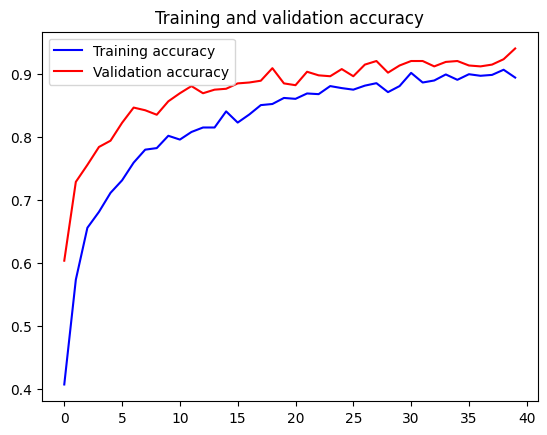

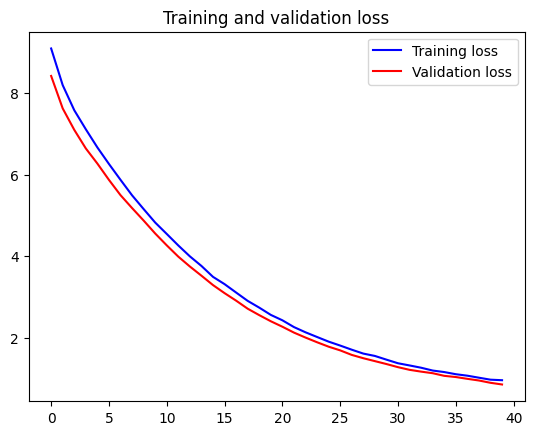

In [24]:
# grafica la funcion de perdida y el accuracy para el dataset de entrenamiento y validacion. 

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

### Predicciones

In [26]:
# Predice la clasificación del conjunto de datos de prueba
pred = model.predict(test_images) # obtiene las probabilidades de clase para cada imagen en test_images
y_pred = np.argmax(pred, axis=1) # convierte las probabilidades en índices de clase

# Mapea la etiqueta
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
preds = [labels[k] for k in y_pred]

# Muestra el resultado
print(f'The first 5 predictions: {preds[:5]}')

28/28 [==============================] - 21s 614ms/step
The first 5 predictions: ['hispa', 'BLB', 'hispa', 'healthy', 'BLB']


### Visualizacion de los reportes de clasificacion y matriz de confusion

In [28]:
# Definir `classes` a partir de las etiquetas
classes = list(labels.values())

In [29]:
# Classification report
print(classification_report(test_images.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

         BLB       0.86      0.95      0.90       176
       Blast       0.92      0.95      0.94       188
     healthy       0.95      0.88      0.91       186
       hispa       0.98      0.99      0.99       170
   leaf_spot       0.95      0.88      0.92       160

    accuracy                           0.93       880
   macro avg       0.93      0.93      0.93       880
weighted avg       0.93      0.93      0.93       880



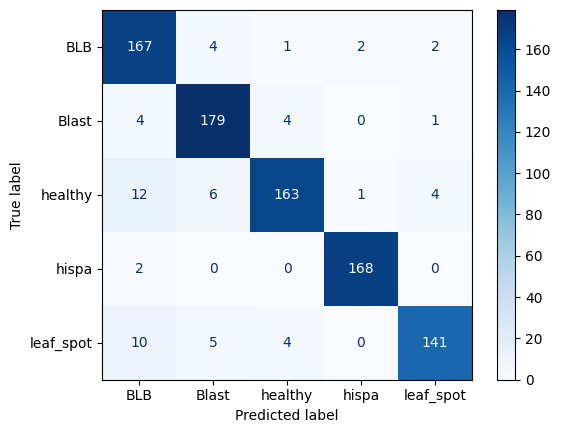

In [30]:
# Confusion matrix
y_true = test_images.classes  # Obtener las etiquetas verdaderas: 'classes' es una propiedad del generador de datos que contiene las etiquetas verdaderas
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(labels[i]) for i in range(num_clases)])
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' para mostrar los números enteros
plt.show()

<h1 style="color: #ADD8E6;"><strong>Explicación matriz de confusión:</strong></h1>

Una matriz de confusión es una tabla que se utiliza para evaluar el rendimiento de un algoritmo de clasificación. Muestra el número de predicciones correctas e incorrectas clasificadas por clase.

<p>Cada <strong>fila</strong> representa la <strong style="color: red;">clase real</strong>, y cada <strong>columna</strong> representa la <strong style="color: red;">clase predicha</strong> por el modelo<p>

<h2 style="color: #DA5F26;"><p><strong>Ejemplo: Interpretación por Fila</strong></p></h2>

*Primera Fila (Clase 0)*

- *167: Imágenes verdaderas de la clase 0 que fueron clasificadas correctamente como clase 0.*
- *4: Imágenes verdaderas de la clase 0 que fueron clasificadas incorrectamente como clase 1.*
- *1: Imágenes verdaderas de la clase 0 que fueron clasificadas incorrectamente como clase 2.*
- *2: Imágenes verdaderas de la clase 0 que fueron clasificadas incorrectamente como clase 3.*
- *2: Imágenes verdaderas de la clase 0 que fueron clasificadas incorrectamente como clase 4.*

<h2 style="color: #DA5F26;"><p><strong>Por lo tanto:</strong></p></h2>

- **Valores Altos en la Diagonal Principal**: Indican que el modelo está clasificando correctamente las imágenes para esas clases.
- **Valores Fuera de la Diagonal**: Indican errores de clasificación donde las imágenes verdaderas de una clase se clasificaron incorrectamente como otra clase.

---
### Conclusiones finales

<span style="background-color: rgba(255, 255, 255, 0.8); color:black; font-weight: bold;">
Según las métricas obtenidas y la matriz de confusión, el modelo demuestra una alta precisión y eficiencia en la predicción de enfermedades en plantas, lo que indica su capacidad para clasificar correctamente la mayoría de las imágenes evaluadas.
</span>